In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import *
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.aqua.algorithms import QSVM
from qiskit_machine_learning.algorithms import QSVR
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.utils import reduce_dim_to_via_pca
from ibm_quantum_widgets import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.linalg import expm
from qiskit.aqua.components.multiclass_extensions import AllPairs
import math
import numpy as np
import matplotlib.pyplot as plt

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

seed = 1000
algorithm_globals.random_seed = seed #

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [2]:
#Instalar paquete scikit-feature selection
!pip install git+https://github.com/jundongl/scikit-feature.git#egg=skfeature
from skfeature.function.similarity_based import SPEC

  Cloning https://github.com/jundongl/scikit-feature.git to /tmp/pip-install-xgd9l15q/skfeature_399a91f12be449e3b61af2f0f9213ee8
  Running command git clone -q https://github.com/jundongl/scikit-feature.git /tmp/pip-install-xgd9l15q/skfeature_399a91f12be449e3b61af2f0f9213ee8
  Created wheel for skfeature: filename=skfeature-1.0.0-py3-none-any.whl size=61508 sha256=639aaf19bd0e8b5d03f2a803d9e0dcb85d8852be472363cd10bc032285e92b92
  Stored in directory: /tmp/pip-ephem-wheel-cache-1tor1zvk/wheels/ea/ca/0b/ea331396461510ff572967528a880848ef75cc192b2f6074eb
Successfully built skfeature


# Leer datos

In [61]:
#Leer fichero de datos
data = pd.read_csv('ETL_Jerarquia_0_v1.csv', sep=';') #leer csv
#Guardar nombres de las columnas
colNames = data.columns
#Crear una copia del dataframe original
OriginalData=data.copy()
#Printear los primeros 5 casos
print(data.head(n=5))

            origh            resph  mehodCount  uriCount  useragentCount  \
0  192.168.202.79  192.168.229.251         200       200             200   
1  192.168.202.79  192.168.229.153           1         1               1   
2  192.168.202.79  192.168.229.101           1         1               1   
3  192.168.202.79  192.168.229.156           1         1               1   
4  192.168.202.76   192.168.28.102           4         4               4   

  requestbodylen_Mean responsebodylenMean   Ano  Mes  dia  diasemana  hora  \
0            0.000000         155.935.000  2012    3   16          6    12   
1            0.000000         326.000.000  2012    3   16          6    12   
2            0.000000         238.000.000  2012    3   16          6    12   
3            0.000000         287.000.000  2012    3   16          6    12   
4            0.000000         169.000.000  2012    3   16          6    12   

   minuto  RecordCount  
0      30          200  
1      30            1  

# Preproceso de datos

In [62]:
#Preprocesar columnas 0-1 (IPs) y 5-6 (valores con millares representados con puntos) 
#Quitar puntos de las columnas
#Columna de IPs
print(data.iloc[:,0].head(n=4))
for i in np.array([0,1,5,6]):
    data.iloc[:,i] = data.iloc[:,i].apply(lambda x: x.replace('.',''))

print("Valor despues de preprocesar puntos: {}".format(data.iloc[0,0]))

0    192.168.202.79
1    192.168.202.79
2    192.168.202.79
3    192.168.202.79
Name: origh, dtype: object
Valor despues de preprocesar puntos: 19216820279


## Eliminar filas que contienen IPv6

In [63]:
#Eliminar filas con IPv6, no se pueden representar como numeros para el qPCA
#Todos los IPv6s comienzan con 2001:dbb, comprobar si hay : entre las posiciones 3 y 5 del string
#para saber si es IPv6
indicesFilas=[]
for i in range (0,len(data)):
    if (data.iloc[i,0].find(':',3,5)!=-1):
        indicesFilas.append(i)

#Eliminar las filas con IPs detectadas como IPv6
data=data.drop(indicesFilas)

#Printear tipos de columnas
print(data.dtypes)
#Poner las columnas preprocesadas en tipo integer ()
data=data.astype('int64') 

origh                  object
resph                  object
mehodCount              int64
uriCount                int64
useragentCount          int64
requestbodylen_Mean    object
responsebodylenMean    object
Ano                     int64
Mes                     int64
dia                     int64
diasemana               int64
hora                    int64
minuto                  int64
RecordCount             int64
dtype: object


## Estandarizar datos

In [64]:
#Estandarizar datos 
data=StandardScaler().fit_transform(data)
#Pasar datos a dataframe 
data=pd.DataFrame(data)
#Reasignar los nombres a las columnas
data.columns = colNames
print(data.head(n=3))

      origh     resph  mehodCount  uriCount  useragentCount  \
0 -1.037148  2.356561   -0.041078 -0.041078       -0.041078   
1 -1.037148  2.356561   -0.121386 -0.121386       -0.121386   
2 -1.037148  2.356561   -0.121386 -0.121386       -0.121386   

   requestbodylen_Mean  responsebodylenMean  Ano  Mes       dia  diasemana  \
0             -0.07588            -0.022519  0.0  0.0 -0.610326  -0.610326   
1             -0.07588            -0.022203  0.0  0.0 -0.610326  -0.610326   
2             -0.07588            -0.022367  0.0  0.0 -0.610326  -0.610326   

       hora    minuto  RecordCount  
0 -1.843207  0.055657    -0.041078  
1 -1.843207  0.055657    -0.121386  
2 -1.843207  0.055657    -0.121386  


# Feature Selection (Spectral)

In [85]:
kwargs = {'style': 1}
feats=SPEC.spec(data.to_numpy(), **kwargs)
print(feats)

[    0.     0.     0.     0.     0.     0.     0. -1000. -1000.     0.
     0.     0.     0.     0.]


In [86]:
#Indices de mayor a menor de los valores de ranking del SPEC feature selection
index = feats.argsort()[::-1]
fsData=data.iloc[:,index[0:4]]

print("Variables seleccionadas: \n", fsData.columns)

Variables seleccionadas: 
 Index(['RecordCount', 'minuto', 'hora', 'diasemana'], dtype='object')


# Feature selection correlation

In [6]:
#Correlaciones entre variables ordenadas de mayor a menor eliminando los pares centrales
correlations=data.corr(method='kendall').abs().unstack().sort_values(ascending=True).drop_duplicates().dropna()
print("Variables con mayor correlacion: \n",correlations)

Variables con mayor correlacion: 
 minuto               Mes                    0.000087
                     responsebodylenMean    0.000088
                     diasemana              0.000806
                     resph                  0.008235
                     dia                    0.011752
                     origh                  0.016445
requestbodylen_Mean  minuto                 0.018118
hora                 minuto                 0.022910
minuto               uriCount               0.023581
RecordCount          Mes                    0.024585
responsebodylenMean  RecordCount            0.024920
minuto               useragentCount         0.025676
                     mehodCount             0.025702
                     Ano                    0.033499
origh                responsebodylenMean    0.044278
resph                origh                  0.045377
diasemana            RecordCount            0.048412
responsebodylenMean  resph                  0.064703
hora       

In [7]:
#Obtener los nombres de los dos pares de variables menos correladas
feats=list(correlations.index[0]+(correlations.index[1][1],)+(correlations.index[2][1],))#original low
#feats=list((correlations.index[1][1],)+(correlations.index[2][1],))#matriz 2x2
#feats=list((correlations.index[55][0],)+(correlations.index[54][0],))#+(correlations.index[53][0],)+(correlations.index[52][0],))
#Escoger las variables de la base de datos original
fsData=data[feats]
print("Variables seleccionadas: \n", fsData.columns)

Variables seleccionadas: 
 Index(['minuto', 'Mes', 'responsebodylenMean', 'diasemana'], dtype='object')


# PCA

In [89]:
#Matriz de covarianza de los datos
cmat = np.cov(data, rowvar=False)
#cmat = np.cov(fsData, rowvar=False)
#print("Matriz de covarianza: \n",cmat.head(n=5)
print(cmat)
#Calcular eigenvalores y eigenvectores
eigenval,eigenvec = np.linalg.eig(cmat)

#Ordenar eigenvalores y eigenvectores de mayor a menor
index = eigenval.argsort()[::-1]
eigenval=eigenval[index]
eigenvec=eigenvec[:,index]
print("Eigenvalores: \n",eigenval.real)
print("Eigenvectores: \n",eigenvec)

explainedVar=eigenval/sum(eigenval)*100
print("Porcentaje varianza explicada: \n", explainedVar.real)
cumVar = explainedVar.cumsum()
print("Porcentaje varianza acumulada: \n", cumVar.real)

#Proyeccion en las nuevas componentes: proyeccion=X(datos)*Eigenvectors(en columnas)
#pcaCoords=np.dot(data, eigenvec[:,0:2].real)
#pcaCoords=np.dot(fsData, eigenvec[:,0:2].real)
#pcaCoords=pd.DataFrame(pcaCoords)
#Plot con pandas
#pcaCoords.plot.scatter(x=0,y=1)

#Obtener las tres primeras componentes del pca para el QSVM
qsvmData =np.dot(data, eigenvec[:,0:8].real)
#qsvmData =np.dot(fsData, eigenvec[:,0:3])

[[ 1.00014736e+00 -9.30564056e-02 -6.76666325e-02 -6.76666325e-02
  -6.76666325e-02  5.50894070e-02 -1.56498675e-02  0.00000000e+00
   0.00000000e+00  9.92607291e-02  9.92607291e-02 -2.17420980e-01
  -1.48911657e-03 -6.76666325e-02]
 [-9.30564056e-02  1.00014736e+00  1.72282504e-01  1.72282504e-01
   1.72282504e-01 -2.85020986e-02 -7.15346019e-03  0.00000000e+00
   0.00000000e+00 -2.02637490e-01 -2.02637490e-01  1.92960676e-01
   3.40253173e-02  1.72282504e-01]
 [-6.76666325e-02  1.72282504e-01  1.00014736e+00  1.00014736e+00
   1.00014736e+00 -8.99527764e-03 -2.52560394e-03  0.00000000e+00
   0.00000000e+00 -6.20956013e-02 -6.20956013e-02  3.73754895e-02
   1.99068762e-02  1.00014736e+00]
 [-6.76666325e-02  1.72282504e-01  1.00014736e+00  1.00014736e+00
   1.00014736e+00 -8.99527764e-03 -2.52560394e-03  0.00000000e+00
   0.00000000e+00 -6.20956013e-02 -6.20956013e-02  3.73754895e-02
   1.99068762e-02  1.00014736e+00]
 [-6.76666325e-02  1.72282504e-01  1.00014736e+00  1.00014736e+00
  

In [90]:
print(qsvmData.shape)

(6787, 8)


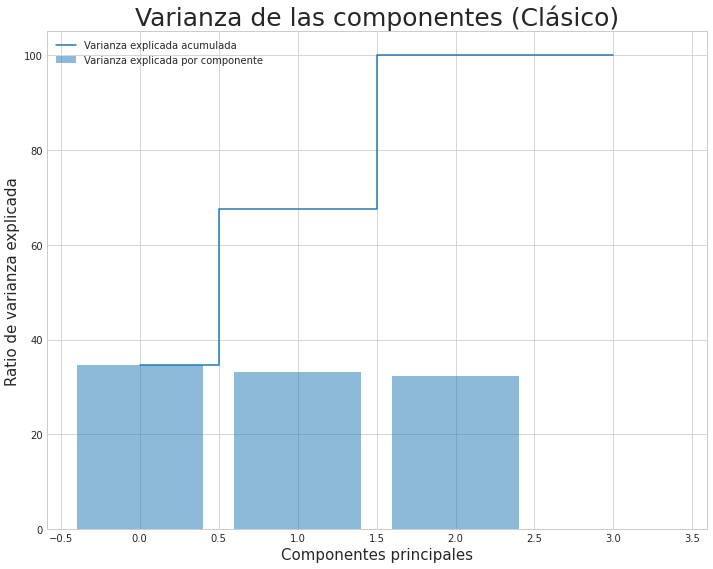

In [9]:
import seaborn as sns
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 8))

    plt.bar(range(4), explainedVar, alpha=0.5, align='center',
            label='Varianza explicada por componente')
    plt.step(range(4), cumVar, where='mid',
             label='Varianza explicada acumulada')
    plt.title('Varianza de las componentes (Clásico)', fontsize=25)
    plt.ylabel('Ratio de varianza explicada', fontsize=15)
    plt.xlabel('Componentes principales', fontsize=15)
    plt.legend(loc='best')
    plt.savefig("VarianzaClasica.pdf", 
               bbox_inches='tight')
    plt.tight_layout()

# QSVRegresor

In [10]:
#Mapa de caracteristicas
feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement='linear')
#feature_map = ZZFeatureMap(feature_dimension=4, reps=4, entanglement='full')
#feature_map = ZFeatureMap(feature_dimension=2, reps=6)
#Instanciacion del simulador
backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)
#Crear quantum kernel con el mapa de caracteristicas y el simulador
kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
#qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension=AllPairs())
qsvr = QSVR(quantum_kernel = kernel)

In [10]:
feature_map = PauliFeatureMap(feature_dimension=2, reps=1, entanglement='linear', paulis=['ZZ'])
#feature_map = ZZFeatureMap(feature_dimension=2, reps=1, entanglement='linear')
print(feature_map)

     ┌───┐                                                                
q_0: ┤ H ├──■──────────────────────────────────────────────────────────■──
     ├───┤┌─┴─┐                                                      ┌─┴─┐
q_1: ┤ H ├┤ X ├──■────────────────────────────────────────────────■──┤ X ├
     ├───┤└───┘┌─┴─┐┌──────────────────────────────────────────┐┌─┴─┐└───┘
q_2: ┤ H ├─────┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])*(π - x[2])) ├┤ X ├─────
     └───┘     └───┘└──────────────────────────────────────────┘└───┘     


In [35]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement='linear')
print(feature_map)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘


In [36]:
feature_map = PauliFeatureMap(feature_dimension=2, reps=2, paulis=['Z'])
print(feature_map)

     ┌───┐┌──────────────┐┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├
     └───┘└──────────────┘└───┘└──────────────┘


In [33]:
feature_map = ZFeatureMap(feature_dimension=2, reps=2)
print(feature_map)

     ┌───┐┌──────────────┐┌───┐┌──────────────┐
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├
     ├───┤├──────────────┤├───┤├──────────────┤
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├
     └───┘└──────────────┘└───┘└──────────────┘


## Prueba fit 100

In [23]:
#Coger 100 filas aleatorias entre la base de datos para la parte de fitting
np.random.seed(999)
ind=np.random.randint(0,len(qsvmData),size = 100)
X=qsvmData[ind,1:3]#.reshape(-1,2)
y=qsvmData[ind,0]
try:
    qsvr.fit(X, y)
except Exception:
    print("Runtime error")

qsvr.score(X,y)

0.15791567951763907

In [11]:
from sklearn.svm import SVR
np.random.seed(999)
ind=np.random.randint(0,len(qsvmData),size = 4000)
X=qsvmData[ind,1:3]#.reshape(-1,2)
y=qsvmData[ind,0]

# Seleccion parametros kernel (gridsearch+cv)

In [34]:
#Coger 100 filas aleatorias entre la base de datos para la parte de fitting
#np.random.seed(999)
#ind=np.random.randint(0,len(qsvmData),size = 4000)
#X=qsvmData[ind,1:3]#.reshape(-1,2)
#y=qsvmData[ind,0]
#import sklearn
#from sklearn.model_selection import GridSearchCV
#svr = SVR(kernel='rbf',C=1000)
##svr=SVR(kernel='rbf',degree=5)
##svr.fit(X,y)
##svr.score(X,y)
#scores=cross_val_score(svr,X,y,scoring='r2')
#print("%0.3f precision con deviacion estandar %0.3f" % (scores.mean(), scores.std()))

In [91]:
np.random.seed(999)
#np.random.seed(111)
#ind=np.random.randint(0,len(qsvmData),size = 75)
#ind=np.random.randint(0,len(qsvmData),size = 120)
ind=np.random.randint(0,len(qsvmData),size = 300)
X=qsvmData[ind,1:9].real#.reshape(-1,2)
y=qsvmData[ind,0].real

In [4]:
np.random.seed(999)
#np.random.seed(111)
#ind=np.random.randint(0,len(qsvmData),size = 75)
#ind=np.random.randint(0,len(qsvmData),size = 120)
ind=np.random.randint(0,len(qsvmData),size = 300)
X=qsvmData[ind,1:3]#.reshape(-1,2)
y=qsvmData[ind,0]

In [ ]:
import sklearn#####UTILIZADO PARA LOS EIGENS QPCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
params= [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
        {'kernel': ['poly'], 'gamma': [1e-3, 1e-4,'scale'],
                     'degree':[2,3,4,5],
                     'C': [1, 10, 100, 1000]},
        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4,'scale'],
                     'C': [1, 10, 100, 1000]},
         {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4,'scale'],
                     'C': [1, 10, 100, 1000]}]
svr = GridSearchCV(SVR(), params, scoring='r2')
#svr=SVR(kernel='rbf',degree=5)
svr.fit(X,y)
#svr.score(X,y)
print("Mejor conjunto de parametros encontrados:\n\n")
print(svr.best_params_)

In [ ]:
means = svr.cv_results_['mean_test_score']
stds = svr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

In [22]:
svr.score(X,y)

0.9974142653508857

In [33]:
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
params= [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
        {'kernel': ['poly'], 'gamma': [1e-3, 1e-4,'scale'],
                     'degree':[2,3,4,5],
                     'C': [1, 10, 100, 1000]},
        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4,'scale'],
                     'C': [1, 10, 100, 1000]},
         {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4,'scale'],
                     'C': [1, 10, 100, 1000]}]
svr = GridSearchCV(SVR(), params, scoring='r2')
#svr=SVR(kernel='rbf',degree=5)
svr.fit(X,y)
#svr.score(X,y)
print("Mejor conjunto de parametros encontrados:\n\n")
print(svr.best_params_)

Mejor conjunto de parametros encontrados:


{'C': 1, 'kernel': 'linear'}


In [34]:
means = svr.cv_results_['mean_test_score']
stds = svr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

0.997 (+/-0.001) for {'C': 1, 'kernel': 'linear'}
0.996 (+/-0.001) for {'C': 10, 'kernel': 'linear'}
0.996 (+/-0.001) for {'C': 100, 'kernel': 'linear'}
0.996 (+/-0.001) for {'C': 1000, 'kernel': 'linear'}
-0.006 (+/-0.013) for {'C': 1, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
-0.006 (+/-0.013) for {'C': 1, 'degree': 2, 'gamma': 0.0001, 'kernel': 'poly'}
0.179 (+/-0.329) for {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
-0.006 (+/-0.013) for {'C': 1, 'degree': 3, 'gamma': 0.001, 'kernel': 'poly'}
-0.006 (+/-0.013) for {'C': 1, 'degree': 3, 'gamma': 0.0001, 'kernel': 'poly'}
0.922 (+/-0.027) for {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
-0.006 (+/-0.013) for {'C': 1, 'degree': 4, 'gamma': 0.001, 'kernel': 'poly'}
-0.006 (+/-0.013) for {'C': 1, 'degree': 4, 'gamma': 0.0001, 'kernel': 'poly'}
0.727 (+/-0.218) for {'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'poly'}
-0.006 (+/-0.013) for {'C': 1, 'degree': 5, 'gamma': 0.001, 'kernel': 'poly'}
-0.006 (

## CV Quantum Kernel

In [57]:
np.random.seed(999)
#np.random.seed(111)
#ind=np.random.randint(0,len(qsvmData),size = 75)
#ind=np.random.randint(0,len(qsvmData),size = 120)
ind=np.random.randint(0,len(qsvmData),size = 300)
if len(cmat)==4:
    X=qsvmData[ind,1:3]#.reshape(-1,2)
    y=qsvmData[ind,0]
elif len(cmat)==2:
    print("2 dimensions")
    X=qsvmData[ind,1].reshape(-1,1)#.reshape(-1,2)
    y=qsvmData[ind,0]

2 dimensions


In [71]:
from sklearn.model_selection import cross_val_score, KFold
from qiskit.circuit.library import EfficientSU2
backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)
#feats=[2,3,4,5]
feats=[2]
#reps=[2,3,4,5]
reps=[2,3,4,5,6,7,8]#mejor el 2 de momento, con qPCA eigens
#entan=['circular','linear', 'full']
entan=['linear']
#paul=[['X']]#,['Y'],['X','XX']]#,['Y','YY'],['X','XY'],['Y','YX']]
paul=[['Y']]#,['X','XX'],['Y','YY']]#,['X','XY'],['Y','YX']]
kf=KFold(n_splits=5)
scores=np.empty(5)
bestScore=0
for i in feats:
    for j in reps:
        for k in entan: 
            for l in paul:#paulifeatmap
                print("params: {}, {}, {}, {}".format(i,j,k,l))
                #print("params: {}, {}, {}".format(i,j,k))
                #feature_map = ZZFeatureMap(feature_dimension=i, reps=j, entanglement=k)
                #feature_map = ZFeatureMap(feature_dimension=i, reps=j)
                feature_map=PauliFeatureMap(feature_dimension=i,reps=j,entanglement=k,paulis=l)#paulifeatmap
                kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
                qsvr = QSVR(quantum_kernel = kernel)
                w=0
                for train_index, test_index in kf.split(X):
                    #X_train, X_test = np.asarray(X[train_index], dtype=np.float64, order='C'),np.asarray(X[test_index], dtype=np.float64, order='C')
                    #y_train, y_test = np.asarray(y[train_index], dtype=np.float64, order='C'),np.asarray(y[test_index], dtype=np.float64, order='C')
                    X_train, X_test = X[train_index],X[test_index]
                    y_train, y_test = y[train_index],y[test_index]
                    try:
                        qsvr.fit(X_train, y_train)
                    except Exception:
                        print("Runtime error")
                    scores[w]=qsvr.score(X_test,y_test)
                    print("\t fitting ", w,"score ", scores[w])
                    w+=1
                if scores.mean()>bestScore:
                        bestScore=scores.mean()
                        print("--------------------BEST SCORE------------------------")
                print("%0.3f precision con desviacion estandar %0.3f\n" % (scores.mean(), scores.std()))
                

params: 2, 2, linear, ['Y']


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0 score  -23.027273928920458


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1 score  -25.08953261185317


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2 score  -32.927637493701255


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3 score  -24.68693014068331


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4 score  -15.892085228078237
-24.325 precision con desviacion estandar 5.432

params: 2, 3, linear, ['Y']


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0 score  0.9035057015615846


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1 score  0.9229621516682079


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2 score  0.9109569303022794


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3 score  0.8727439270175804


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4 score  0.9489658171556873
--------------------BEST SCORE------------------------
0.912 precision con desviacion estandar 0.025

params: 2, 4, linear, ['Y']


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0 score  -23.027273928920458


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1 score  -25.08953261185317


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2 score  -32.927637493701255


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3 score  -24.68693014068331


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4 score  -15.892085228078237
-24.325 precision con desviacion estandar 5.432

params: 2, 5, linear, ['Y']


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0 score  0.9035057015615846


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1 score  0.9229621516682079


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2 score  0.9109569303022794


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3 score  0.8727439270175804


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4 score  0.9489658171556873
0.912 precision con desviacion estandar 0.025

params: 2, 6, linear, ['Y']


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0 score  -23.027273928920458


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1 score  -25.08953261185317


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2 score  -32.927637493701255


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3 score  -24.68693014068331


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4 score  -15.892085228078237
-24.325 precision con desviacion estandar 5.432

params: 2, 7, linear, ['Y']


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0 score  0.9035057015615846


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1 score  0.9229621516682079


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2 score  0.9109569303022794


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3 score  0.8727439270175804


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4 score  0.9489658171556873
0.912 precision con desviacion estandar 0.025

params: 2, 8, linear, ['Y']


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0 score  -23.027273928920458


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1 score  -25.08953261185317


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2 score  -32.927637493701255


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3 score  -24.68693014068331


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4 score  -15.892085228078237
-24.325 precision con desviacion estandar 5.432



### print(X_train.shape)

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from qiskit.circuit.library import EfficientSU2
backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)
#feats=[2,3,4,5]
feats=[2]
#reps=[2,3,4,5]
reps=[2,3,4,5,6,7,8]
#entan=['circular','linear', 'full']
entan=['linear']
paul=[['X']]#,['Y'],['X','XX']]#,['Y','YY'],['X','XY'],['Y','YX']]
kf=KFold(n_splits=5)
scores=np.empty(5)
bestScore=0
for i in feats:
    for j in reps:
        for k in entan: 
            #for l in paul:#paulifeatmap
                #print("params: {}, {}, {}, {}".format(i,j,k,l))
            print("params: {}, {}, {}".format(i,j,k))
            feature_map = ZZFeatureMap(feature_dimension=i, reps=j, entanglement=k)
            #feature_map = ZFeatureMap(feature_dimension=i, reps=j)
            #feature_map=PauliFeatureMap(feature_dimension=i,reps=j,entanglement=k,paulis=l)#paulifeatmap
            kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
            qsvr = QSVR(quantum_kernel = kernel)
            w=0
            for train_index, test_index in kf.split(X):
                #X_train, X_test = np.asarray(X[train_index], dtype=np.float64, order='C'),np.asarray(X[test_index], dtype=np.float64, order='C')
                #y_train, y_test = np.asarray(y[train_index], dtype=np.float64, order='C'),np.asarray(y[test_index], dtype=np.float64, order='C')
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                try:
                    qsvr.fit(X_train, y_train)
                except Exception:
                    print("Runtime error")
                print("\t fitting ", w)
                scores[w]=qsvr.score(X_test,y_test)
                print("\t fitting ", w,"score ", scores[w])
                w+=1
            if scores.mean()>bestScore:
                    bestScore=scores.mean()
                    print("--------------------BEST SCORE------------------------")
            print("%0.3f precision con desviacion estandar %0.3f\n" % (scores.mean(), scores.std()))
                

In [67]:
from sklearn.model_selection import cross_val_score, KFold
from qiskit.circuit.library import EfficientSU2
backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=seed, seed_transpiler=seed)
#feats=[2,3,4,5]
feats=[2]
#reps=[2,3,4,5]
reps=[2,3,4,5,6,7,8]
#entan=['circular','linear', 'full']
entan=['linear']
paul=[['X']]#,['Y'],['X','XX']]#,['Y','YY'],['X','XY'],['Y','YX']]
kf=KFold(n_splits=5)
scores=np.empty(5)
bestScore=0
for i in feats:
    for j in reps:
        for k in entan: 
            #for l in paul:#paulifeatmap
                #print("params: {}, {}, {}, {}".format(i,j,k,l))
            print("params: {}, {}, {}".format(i,j,k))
            #feature_map = ZZFeatureMap(feature_dimension=i, reps=j, entanglement=k)
            feature_map = ZFeatureMap(feature_dimension=i, reps=j)
            #feature_map=PauliFeatureMap(feature_dimension=i,reps=j,entanglement=k,paulis=l)#paulifeatmap
            kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
            qsvr = QSVR(quantum_kernel = kernel)
            w=0
            for train_index, test_index in kf.split(X):
                #X_train, X_test = np.asarray(X[train_index], dtype=np.float64, order='C'),np.asarray(X[test_index], dtype=np.float64, order='C')
                #y_train, y_test = np.asarray(y[train_index], dtype=np.float64, order='C'),np.asarray(y[test_index], dtype=np.float64, order='C')
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                try:
                    qsvr.fit(X_train, y_train)
                except Exception:
                    print("Runtime error")
                print("\t fitting ", w)
                scores[w]=qsvr.score(X_test,y_test)
                print("\t fitting ", w,"score ", scores[w])
                w+=1
            if scores.mean()>bestScore:
                    bestScore=scores.mean()
                    print("--------------------BEST SCORE------------------------")
            print("%0.3f precision con desviacion estandar %0.3f\n" % (scores.mean(), scores.std()))
                

params: 2, 2, linear


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0
	 fitting  0 score  -4.718372617157475


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1
	 fitting  1 score  -3.711914314245978


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2
	 fitting  2 score  -1.3566246092858005


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3
	 fitting  3 score  -3.705670013417101


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4
	 fitting  4 score  -4.161237393928987
-3.531 precision con desviacion estandar 1.149

params: 2, 3, linear


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0
	 fitting  0 score  -1.7676133308135875


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1
	 fitting  1 score  -0.18790506467110646


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2
	 fitting  2 score  -2.5083735766486526


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3
	 fitting  3 score  -14.655924869229382


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4
	 fitting  4 score  -8.508663389052787
-5.526 precision con desviacion estandar 5.366

params: 2, 4, linear


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0
	 fitting  0 score  0.8058235016641572


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1
	 fitting  1 score  0.8312428336476432


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2
	 fitting  2 score  0.7222602049035984


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3
	 fitting  3 score  0.8093461285255373


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4
	 fitting  4 score  0.8785944702514864
--------------------BEST SCORE------------------------
0.809 precision con desviacion estandar 0.051

params: 2, 5, linear


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0
	 fitting  0 score  0.7558935901347068


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1
	 fitting  1 score  0.7857570382121337


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2
	 fitting  2 score  0.7473937559707429


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3
	 fitting  3 score  0.8040482193670324


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4
	 fitting  4 score  0.8560868501283911
0.790 precision con desviacion estandar 0.039

params: 2, 6, linear


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0
	 fitting  0 score  -1.3023510827025295


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1
	 fitting  1 score  -0.7754406274489078


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2
	 fitting  2 score  -0.7840773439848894


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3
	 fitting  3 score  -1.3408498547441523


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4
	 fitting  4 score  -0.27187309733257314
-0.895 precision con desviacion estandar 0.395

params: 2, 7, linear


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0
	 fitting  0 score  -12.250941598141786


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1
	 fitting  1 score  -3.7385807523594625


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2
	 fitting  2 score  -4.642552345476804


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3
	 fitting  3 score  -30.139539754007014


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4
	 fitting  4 score  -3.486281118548461
-10.852 precision con desviacion estandar 10.172

params: 2, 8, linear


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  0
	 fitting  0 score  -0.9068206566470625


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  1
	 fitting  1 score  -0.8969229871979421


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  2
	 fitting  2 score  -2.4205969645667036


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  3
	 fitting  3 score  -3.4768830727739637


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


	 fitting  4
	 fitting  4 score  -11.26409644802734
-3.793 precision con desviacion estandar 3.861



In [72]:
#feature_map=PauliFeatureMap(feature_dimension=2,reps=8,entanglement='linear',paulis=['X'])

#backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                #seed_simulator=seed, seed_transpiler=seed)
feature_map=PauliFeatureMap(feature_dimension=2,reps=2,entanglement='linear',paulis=['X'])    
backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024, seed_simulator=seed, seed_transpiler=seed)
#Crear quantum kernel con el mapa de caracteristicas y el simulador
kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
#qsvm = QSVM(feature_map, training_input, test_input, multiclass_extension=AllPairs())
qsvr = QSVR(quantum_kernel = kernel)
scores=np.empty(5)
w=0
for train_index, test_index in kf.split(X):
                #X_train, X_test = np.asarray(X[train_index], dtype=np.float64, order='C'),np.asarray(X[test_index], dtype=np.float64, order='C')
                #y_train, y_test = np.asarray(y[train_index], dtype=np.float64, order='C'),np.asarray(y[test_index], dtype=np.float64, order='C')
                X_train, X_test = X[train_index],X[test_index]
                y_train, y_test = y[train_index],y[test_index]
                try:
                    qsvr.fit(X_train, y_train)
                except Exception:
                    print("Runtime error")
                print("asd ",w)
                scores[w]=qsvr.score(X_test,y_test)
                w+=1
                print(w)
print("%0.3f precision con desviacion estandar %0.3f\n" % (scores.mean(), scores.std()))

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


asd  0
1


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


asd  1
2


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


asd  2
3


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


asd  3
4


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


asd  4
5
0.912 precision con desviacion estandar 0.025



## Prediccion del modelo entrenado

In [83]:
#Eliminar los casos escogidos para la fase de fitting
#newData=[element for i, element in enumerate(qsvmData) if i not in ind]
#print("Tamaño de la nueva base de datos: {}, y de la original: {}".format(len(newData),len(qsvmData)))
output=np.zeros(len(qsvmData))
print(output[0:5])
for i in range (0,len(qsvmData),100):
    #Separar el ultimo caso con menos de 100 datos
    if i==6700:
        #output[i:i+87]=qsvr.predict(qsvmData[i:i+87,1:3])
        #output[i:i+87]=svr.predict(qsvmData[i:i+87,1:3])
        #output[i:i+87]=svr.predict(qsvmData[i:i+87,1:15].real)
        output[i:i+87]=svr.predict(data.to_numpy()[i:i+87,1:15].real)
    else:
        #output[i:i+100]=qsvr.predict(qsvmData[i:i+100,1:3])    
        #output[i:i+100]=svr.predict(qsvmData[i:i+100,1:3])
        #output[i:i+100]=svr.predict(qsvmData[i:i+100,1:15].real)
        output[i:i+100]=svr.predict(data.to_numpy()[i:i+100,1:15].real)
    print("Indice: ", i)

#print(qsvr.predict(X).head(n=20))
#print("Real values: \n", y[0:21])

[0. 0. 0. 0. 0.]
Indice:  0
Indice:  100
Indice:  200
Indice:  300
Indice:  400
Indice:  500
Indice:  600
Indice:  700
Indice:  800
Indice:  900
Indice:  1000
Indice:  1100
Indice:  1200
Indice:  1300
Indice:  1400
Indice:  1500
Indice:  1600
Indice:  1700
Indice:  1800
Indice:  1900
Indice:  2000
Indice:  2100
Indice:  2200
Indice:  2300
Indice:  2400
Indice:  2500
Indice:  2600
Indice:  2700
Indice:  2800
Indice:  2900
Indice:  3000
Indice:  3100
Indice:  3200
Indice:  3300
Indice:  3400
Indice:  3500
Indice:  3600
Indice:  3700
Indice:  3800
Indice:  3900
Indice:  4000
Indice:  4100
Indice:  4200
Indice:  4300
Indice:  4400
Indice:  4500
Indice:  4600
Indice:  4700
Indice:  4800
Indice:  4900
Indice:  5000
Indice:  5100
Indice:  5200
Indice:  5300
Indice:  5400
Indice:  5500
Indice:  5600
Indice:  5700
Indice:  5800
Indice:  5900
Indice:  6000
Indice:  6100
Indice:  6200
Indice:  6300
Indice:  6400
Indice:  6500
Indice:  6600
Indice:  6700


## Guardar predicciones en un fichero

In [75]:
print(output[0:5])
np.savetxt('prediccionesFULLCLASIC-14DimsOneClassSVM.csv', output, delimiter=',', fmt='%1.8f')#Escribir en fichero con 8 decimales de precision
#np.savetxt('prediccionesQPCA_NormalSVM_4DIM.csv', output, delimiter=',', fmt='%1.8f')#Escribir en fichero con 8 decimales de precision

[1. 1. 1. 1. 1.]


In [37]:
#output=pd.read_csv('predicciones.csv', sep=',', header=None).to_numpy().reshape(-1) #leer fichero de predicciones
output=pd.read_csv('prediccionesFULLCLASIC-14DimsOneClassSVM.csv', sep=',', header=None).to_numpy().reshape(-1) #leer fichero de predicciones
#output=pd.read_csv('prediccionesQPCA_QuantumSVM_4DIM_PFM-2q-2r-LIN-X_FS_CORR.csv', sep=',', header=None).to_numpy().reshape(-1) 
print(output[0:5])

[-1. -1. -1. -1. -1.]


In [84]:
print(output[0:10])

[-0.5355175  -0.53267941 -0.53260168 -0.53357824  0.14610246  0.05576107
  0.04413732  0.03664198  0.03440042  0.03737572]


In [84]:
#Calcular el error: sqrt((a-b)^2)
errors = [math.sqrt((qsvmData[i,0]-output[i])**2) for i in range(len(qsvmData[:,0]))]
print(errors[0:5])
print("Error total: ", sum(errors))
print("Error maximo: ", max(errors))
print("Media error: ", sum(errors)/len(errors))

[0.7087381264775074, 0.8668200836988413, 0.8668199306330561, 0.8668200158116639, 1.1959787200442265]
Error total:  7815.491358171363
Error maximo:  82.20605098473526
Media error:  1.1515384349744162


In [85]:
#Crear columna de fecha (uniendo las columnas de año, mes, dia, hora y minuto)
OriginalData["Fecha"] = pd.to_datetime(OriginalData["Ano"].astype(str) +'-'+ OriginalData["Mes"].astype(str) +'-'+ OriginalData["dia"].astype(str) +' '+ OriginalData["hora"].astype(str) +':'+ OriginalData["minuto"].astype(str))  
#Convertir el vector de errores en columna de pandas
OriginalData["Error"] = pd.Series(errors)
print(OriginalData.head(5))

            origh            resph  mehodCount  uriCount  useragentCount  \
0  192.168.202.79  192.168.229.251         200       200             200   
1  192.168.202.79  192.168.229.153           1         1               1   
2  192.168.202.79  192.168.229.101           1         1               1   
3  192.168.202.79  192.168.229.156           1         1               1   
4  192.168.202.76   192.168.28.102           4         4               4   

  requestbodylen_Mean responsebodylenMean   Ano  Mes  dia  diasemana  hora  \
0            0.000000         155.935.000  2012    3   16          6    12   
1            0.000000         326.000.000  2012    3   16          6    12   
2            0.000000         238.000.000  2012    3   16          6    12   
3            0.000000         287.000.000  2012    3   16          6    12   
4            0.000000         169.000.000  2012    3   16          6    12   

   minuto  RecordCount               Fecha     Error   Color  Tipo  
0    

2012-03-16 12:30:00 2012-03-17 20:46:00


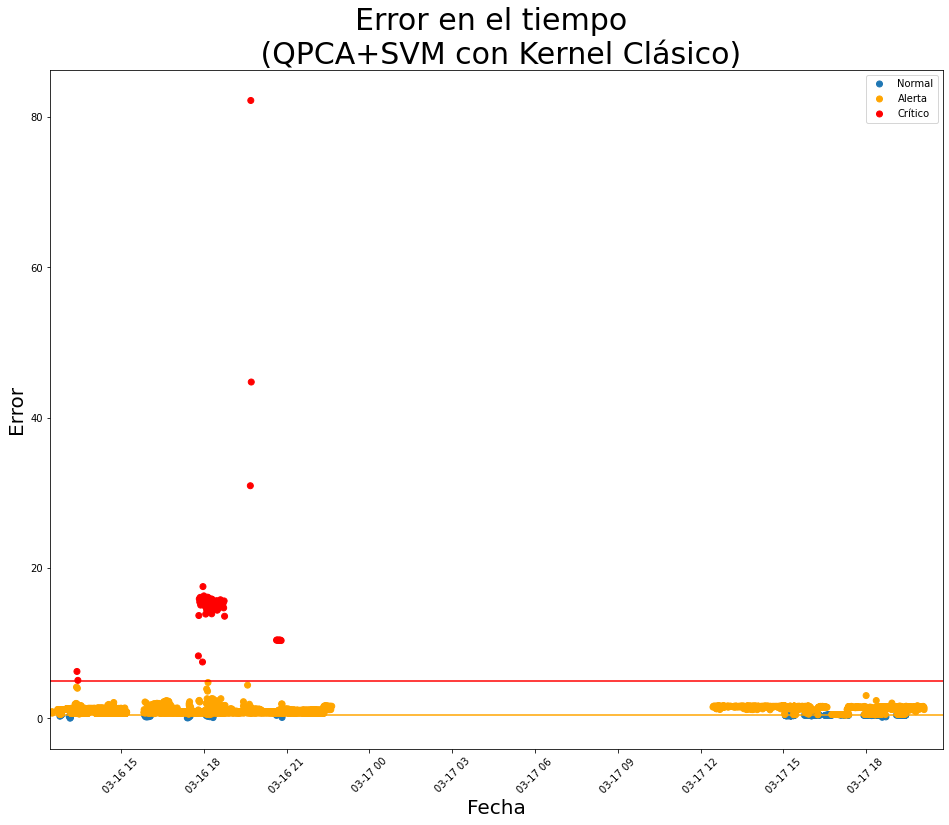

# Pruebas eigenvalues a mano

In [8]:
#Función para calcular el eigenvalue correspondiente al eigenvector v, 
#la matriz de covarianza covmat y el conjunto de datos data
#Devuelve el eigenvector y la matriz de covarianza actualizada
def eigenvalue(v, covmat, data):    
    #Calcular las proyecciones de cada punto al eigenvector: ((P*u1)/(u1*u1)*u1
    projections=data.to_numpy().dot(v)/np.dot(v,v)
    #Multiplicar vector con todos los escalares por el vector unitario (primer eigenvector)
    pointProjections=np.outer(projections,v)
    #Calcular las distancias de todos los puntos obtenidos al origen
    zero=np.zeros(data.shape[1])
    #Calcular las distancias al cuadrado de todos los puntos projectados y el origen para obtener el eigenvalue
    distance=np.linalg.norm(pointProjections - zero)**2
    #Dividir el eigenalue entre n-1 para obtener la variacion del componente pc1
    eigenvalue=distance/6786
    #Actualzar matriz de covarianza, B=A-lambda1*(v*v^T)/(v*v)^2
    cmatUpdated=covmat-eigenvalue*np.outer(v,v)/(np.dot(v,v)**2)
    
    #Devolver el eigenvalue obtenido y la matriz de covarianza actualizada
    return round(eigenvalue,8), cmatUpdated

#xd, c=eigenvalue(eigenvec[:,0],cmat,fsData)

In [78]:
#Calcular las proyecciones de cada punto al eigenvector: ((P*u1)/(u1*u1)*u1
v=eigenvec[:,0].real
#Metodo 1 (apply mas lento):
#pointProjections=pd.DataFrame(data.apply(lambda x: (np.dot(x,v)/np.dot(v,v))*v, axis=1))
#print(pointProjections.head(5))

#Metodo 2: 
projections=data.to_numpy().dot(v)/np.dot(v,v)
#Multiplicar vector con todos los escalares por el vector unitario (primer eigenvector)
pointProjections=np.outer(projections,v)
print(pointProjections[0:5,:])

[[-1.59562714e-02  3.62457382e-02  1.43331621e-01  1.43331621e-01
   1.43331621e-01 -2.62985527e-03 -2.72529531e-04 -0.00000000e+00
  -0.00000000e+00 -2.17324013e-02 -2.17324013e-02  1.11327371e-02
   3.71290116e-03  1.43331621e-01]
 [-7.29602834e-03  1.65734166e-02  6.55385927e-02  6.55385927e-02
   6.55385927e-02 -1.20250516e-03 -1.24614525e-04 -0.00000000e+00
  -0.00000000e+00 -9.93717219e-03 -9.93717219e-03  5.09046025e-03
   1.69772947e-03  6.55385927e-02]
 [-7.29603673e-03  1.65734357e-02  6.55386680e-02  6.55386680e-02
   6.55386680e-02 -1.20250654e-03 -1.24614669e-04 -0.00000000e+00
  -0.00000000e+00 -9.93718361e-03 -9.93718361e-03  5.09046610e-03
   1.69773142e-03  6.55386680e-02]
 [-7.29603206e-03  1.65734251e-02  6.55386261e-02  6.55386261e-02
   6.55386261e-02 -1.20250577e-03 -1.24614589e-04 -0.00000000e+00
  -0.00000000e+00 -9.93717725e-03 -9.93717725e-03  5.09046284e-03
   1.69773033e-03  6.55386261e-02]
 [ 1.07363508e-02 -2.43883393e-02 -9.64422405e-02 -9.64422405e-02
  

In [11]:
#Calcular las distancias de todos los puntos obtenidos al origen
zero=np.zeros(data.shape[1])
#Calcular las distancias al cuadrado de todos los puntos projectados y el origen para obtener el eigenvalue
distance=np.linalg.norm(pointProjections - zero)**2
#Dividir el eigenvalue entre n-1 para obtener la variacion del componente pc1
eigenvalue1=distance/6786
print(eigenvalue1)

4.074108013728111


In [46]:
#Actualzar matriz de covarianza, B=A-lambda1*(v*v^T)/(v*v)^2
cmatUpdated=cmat-eigenvalue1*np.outer(v,v)/(np.dot(v,v)**2)
print(cmat[0:2,0:2])
print(cmatUpdated[0:2,0:2])

[[ 1.00014736 -0.09305641]
 [-0.09305641  1.00014736]]
[[ 0.98792013 -0.06528143]
 [-0.06528143  0.93705466]]


In [50]:
eigenval2,eigenvec2 = np.linalg.eig(cmatUpdated)

#Ordenar eigenvalores y eigenvectores de mayor a menor
index2 = eigenval2.argsort()[::-1]
eigenval2=eigenval2[index2]
eigenvec2=eigenvec2[:,index2]
print("Mayor eigenvalue despues de aplicar formula: ",eigenval2.real[0])
print("Segundo mayor eigenvalue antes de aplicar formula: ",eigenval.real[1])


Mayor eigenvalue despues de aplicar formula:  2.081786773762993
Segundo mayor eigenvalue antes de aplicar formula:  2.0817867737629974


In [ ]:
#Matriz de covarianza de los datos
cmat = np.cov(data, rowvar=False)
#print("Matriz de covarianza: \n",cmat.head(n=5)

#Calcular eigenvalores y eigenvectores
eigenval,eigenvec = np.linalg.eig(cmat)

#Ordenar eigenvalores y eigenvectores de mayor a menor
index = eigenval.argsort()[::-1]
eigenval=eigenval[index]
eigenvec=eigenvec[:,index]

# Circuito 4 qubits

In [16]:
m = sys.maxsize
minIndex=-1
for i,b in enumerate(provider.backends()):
    try:
        #qcount=b.configuration().n_qubits
        qcount=len(b.properties().qubits)
    except:
        qcount="(simulador) "+ str(b.configuration().n_qubits)
    if qcount==5 and b.status().pending_jobs<m: 
        m = b.status().pending_jobs
        minIndex=i
    print("{}, lista de espera: {}, {} qubits".format(b.name(), b.status().pending_jobs, qcount))

backend=provider.backends()[minIndex]
print("\n El backend real con menor cola de espera: ", backend.name())

ibmq_qasm_simulator, lista de espera: 4, (simulador) 32 qubits
ibmq_armonk, lista de espera: 23, 1 qubits
ibmq_santiago, lista de espera: 38, 5 qubits
ibmq_bogota, lista de espera: 4, 5 qubits
ibmq_lima, lista de espera: 4, 5 qubits
ibmq_belem, lista de espera: 3, 5 qubits
ibmq_quito, lista de espera: 0, 5 qubits
simulator_statevector, lista de espera: 2, (simulador) 32 qubits
simulator_mps, lista de espera: 2, (simulador) 100 qubits
simulator_extended_stabilizer, lista de espera: 2, (simulador) 63 qubits
simulator_stabilizer, lista de espera: 2, (simulador) 5000 qubits
ibmq_manila, lista de espera: 6, 5 qubits

 El backend real con menor cola de espera:  ibmq_quito


In [10]:
#Matriz de covarianza de los datos
cmat = np.cov(fsData, rowvar=False)
print("Matriz de covarianza: \n",cmat)

#Calcular eigenvalores y eigenvectores
eigenval,eigenvec = np.linalg.eig(cmat)

#Ordenar eigenvalores y eigenvectores de mayor a menor
index = eigenval.argsort()[::-1]
eigenval=eigenval[index]
eigenvec=eigenvec[:,index]

print("Eigenvalores: \n",np.round(eigenval.real,4))
print("Eigenvectores: \n",np.round(eigenvec,4))

Matriz de covarianza: 
 [[ 1.00014736  0.         -0.01996658  0.02584158]
 [ 0.          0.          0.          0.        ]
 [-0.01996658  0.          1.00014736 -0.00782766]
 [ 0.02584158  0.         -0.00782766  1.00014736]]
Eigenvalores: 
 [1.0369 0.9926 0.971  0.    ]
Eigenvectores: 
 [[ 0.6643  0.0676  0.7444  0.    ]
 [ 0.      0.      0.      1.    ]
 [-0.4829  0.799   0.3584  0.    ]
 [ 0.5706  0.5976 -0.5633  0.    ]]


In [32]:
p=cmat/cmat.trace()
print(p)
eigenval,eigenvec = np.linalg.eig(p)

#Ordenar eigenvalores y eigenvectores de mayor a menor
index = eigenval.argsort()[::-1]
eigenval=eigenval[index]
eigenvec=eigenvec[:,index]

print("Eigenvalores: \n",np.round(eigenval.real,4))
print("Eigenvectores: \n",np.round(eigenvec,4))

[[ 0.5        -0.00391326]
 [-0.00391326  0.5       ]]
Eigenvalores: 
 [0.5039 0.4961]
Eigenvectores: 
 [[ 0.7071  0.7071]
 [-0.7071  0.7071]]


In [18]:
#Inicializar vector de estado (superposicion)
#stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
#stateVec2 = [1/np.sqrt(2), 1/np.sqrt(2)]
stateVec=[1/2,1/2,1/2,1/2]
#Repetir proceso para mayor precision
for i in range(0, 20):
    #Crear circuito con 5 qubits
    circuit = QuantumCircuit(5,5)
    #Inicializacion qubit 4 en estado de superposicion
    #circuit.initialize(stateVec, 4)
    #circuit.initialize(stateVec2, 5)
    circuit.initialize(stateVec, [3,4])
    #Aplicar puertas de hadamard a qubits 0,1,2,3 para aplicar Quantum Amplitude Estimation sobre la matriz unitaria
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.h(3)
    #Calcular rotaciones de la puerta de la matriz unitaria
    (theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p))
    #Aplicar rotaciones
    circuit.cu(theta,phi,lamb,0, 2, [3,4])
    #Calcular rotaciones de la puerta de la matriz unitaria aplicada dos veces, Quantum Amplitude Estimation
    (theta2, phi2, lamb2) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*2))
    #Aplicar rotaciones
    circuit.cu(theta2,phi2,lamb2,0, 1, [3,4])
    #Calcular rotaciones de la puerta de la matriz unitaria aplicada cuatro veces, Quantum Amplitude Estimation
    (theta3, phi3, lamb3) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*4))
    #Aplicar rotaciones
    circuit.cu(theta3,phi3,lamb3,0, 0, [3,4])
    
    #Aplicar Quantum Fourier Transform en los qubits 0,1,2,3
    circuit.h(0)
    circuit.crz(-np.pi/2,0,1)
    circuit.h(1)
    circuit.crz(-np.pi/2,1,2)
    circuit.crz(-np.pi/4,0,2)
    circuit.h(2)
    
    #Medir los qubits
    circuit.measure([0,1,2,3,4], [0,1,2,3,4])
    #Ejecutar circuito en el simulador y guardar resultados obtenidos
    #results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=4096).result().get_counts()
    results = execute(circuit, backend=backend, shots=4096).result().get_counts()
    #print(results)
    denominator = results['00111'] + results['01111'] + results['10111'] + results['11111']
    
    #Calcular coeficientes del eigenvector
    alpha1 = np.sqrt(results['00111'] / denominator)
    alpha2 = np.sqrt(results['01111'] / denominator)
    alpha3 = np.sqrt(results['10111'] / denominator)
    alpha4 = np.sqrt(results['11111'] / denominator)
    
    #Guardar nuevo estado inicial para la siguiente ejecucion
    stateVec = [alpha1, alpha2, alpha3, alpha4]
    #tateVec2 = [alpha3, alpha4]
    print("Iteracion ",i)
    print("Eigenvector obtenido: ",stateVec)
#print("Eigenvector obtenido: ",stateVec, stateVec2)

Iteracion  0
Eigenvector obtenido:  [0.738180316481494, 0.2447043921161982, 0.6043752651108782, 0.17303213505149567]
Iteracion  1
Eigenvector obtenido:  [0.6631110857591943, 0.44162819315902807, 0.4874306642818746, 0.3572948005052482]
Iteracion  2
Eigenvector obtenido:  [0.7308635239791557, 0.4244104423815282, 0.47286624374346037, 0.24922239313961342]
Iteracion  3
Eigenvector obtenido:  [0.7172815023567723, 0.20851441405707477, 0.6138498140448513, 0.2553769592276246]
Iteracion  4
Eigenvector obtenido:  [0.695221787153807, 0.3651483716701107, 0.5400617248673217, 0.30276503540974914]
Iteracion  5
Eigenvector obtenido:  [0.7486251134176307, 0.3779644730092272, 0.4322189107537832, 0.33149677206589795]
Iteracion  6
Eigenvector obtenido:  [0.6697746866231371, 0.47360222277831504, 0.5206035318581478, 0.23680111138915752]
Iteracion  7
Eigenvector obtenido:  [0.7879816195062792, 0.3877199986918664, 0.4277926319464986, 0.2138963159732493]
Iteracion  8
Eigenvector obtenido:  [0.7197121726848806, 

## Prueba sin loop

Traceback (most recent call last):
  File "/tmp/ipykernel_39/749728415.py", line 51, in <module>
    denominator = results['001111'] + results['101111'] + results['011111'] + results['111111']
KeyError: '101111'

Use %tb to get the full traceback.


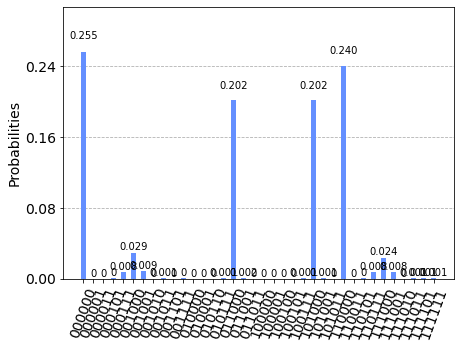

In [19]:
stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
stateVec2 = [1/np.sqrt(2), 1/np.sqrt(2)]
#Crear circuito con 5 qubits
circuit = QuantumCircuit(6,6)

#Inicializacion qubit 4 en estado de superposicion
circuit.initialize(stateVec, 4)
circuit.initialize(stateVec2, 5)

#Aplicar puertas de hadamard a qubits 0,1,2,3 para aplicar Quantum Amplitude Estimation sobre la matriz unitaria
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)

#Calcular rotaciones de la puerta de la matriz unitaria
(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p))
#Aplicar rotaciones
circuit.cu(theta,phi,lamb,0, 3, [4,5])
#Calcular rotaciones de la puerta de la matriz unitaria aplicada dos veces, Quantum Amplitude Estimation
(theta2, phi2, lamb2) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*2))
#Aplicar rotaciones
circuit.cu(theta2,phi2,lamb2,0, 2, [4,5])
#Calcular rotaciones de la puerta de la matriz unitaria aplicada cuatro veces, Quantum Amplitude Estimation
(theta3, phi3, lamb3) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*4))
#Aplicar rotaciones
circuit.cu(theta3,phi3,lamb3,0, 1, [4,5])
#Calcular rotaciones de la puerta de la matriz unitaria aplicada ocho veces, Quantum Amplitude Estimation
(theta4, phi4, lamb4) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*8))
#Aplicar rotaciones
circuit.cu(theta4,phi4,lamb4,0, 0, [4,5])

#Aplicar Quantum Fourier Transform en los qubits 0,1,2,3
circuit.h(0)
circuit.crz(-np.pi/2,0,1)
circuit.h(1)
circuit.crz(-np.pi/2,1,2)
circuit.crz(-np.pi/4,0,2)
circuit.h(2)
circuit.crz(-np.pi/2,2,3)
circuit.crz(-np.pi/4,1,3)
circuit.crz(-np.pi/8,0,3)
circuit.h(3)

#Medir los qubits
circuit.measure([0,1,2,3,4,5], [0,1,2,3,4,5])
#Ejecutar circuito en el simulador y guardar resultados obtenidos
results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=10000).result().get_counts()
plot_histogram(results)
#denominator = results['000000'] + results['101001'] + results['000111'] + results['100111']
denominator = results['001111'] + results['101111'] + results['011111'] + results['111111']  
#Calcular coeficientes del eigenvector en proyeccion 1111 (00,01,10,11); segunda proyeccion en 1110 segundo eigenvec????? 
alpha1 = np.sqrt(results['001111'] / denominator)
alpha2 = np.sqrt(results['101111'] / denominator)
alpha3 = np.sqrt(results['011111'] / denominator)
alpha4 = np.sqrt(results['111111'] / denominator)

#Guardar nuevo estado inicial para la siguiente ejecucion
stateVec = [alpha1, alpha2]
stateVec2 = [alpha3, alpha4]

print("Eigenvector obtenido: ", stateVec + stateVec2)

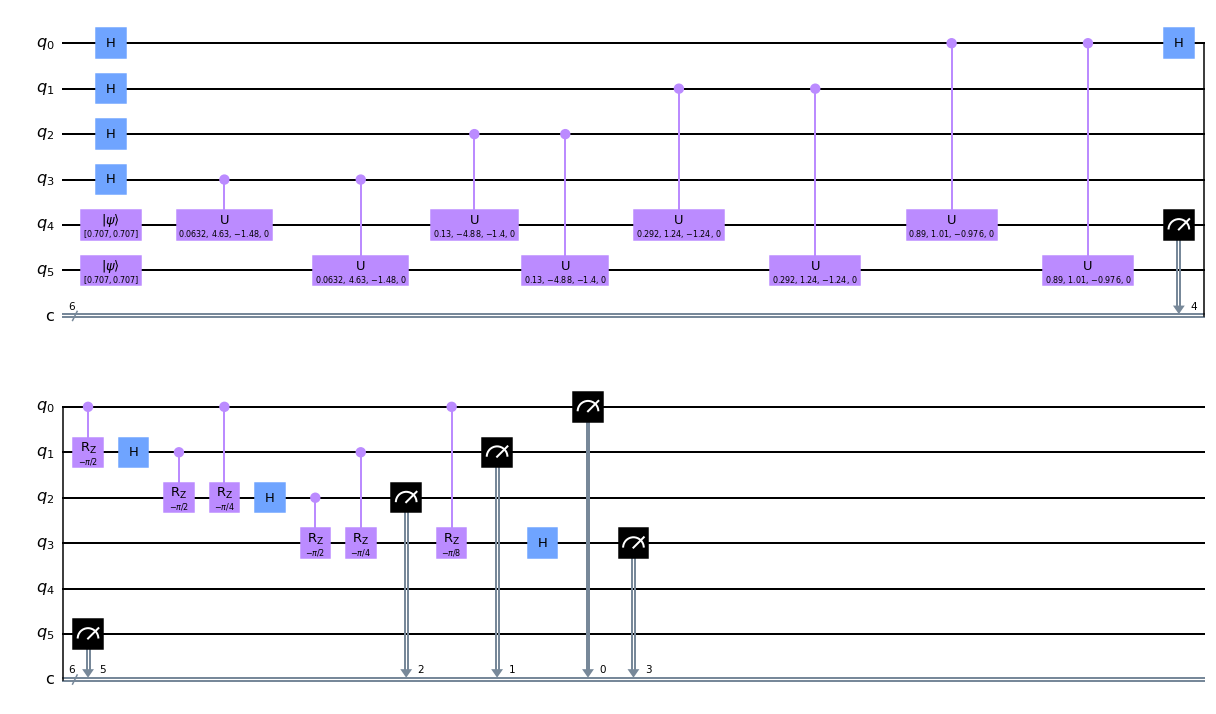

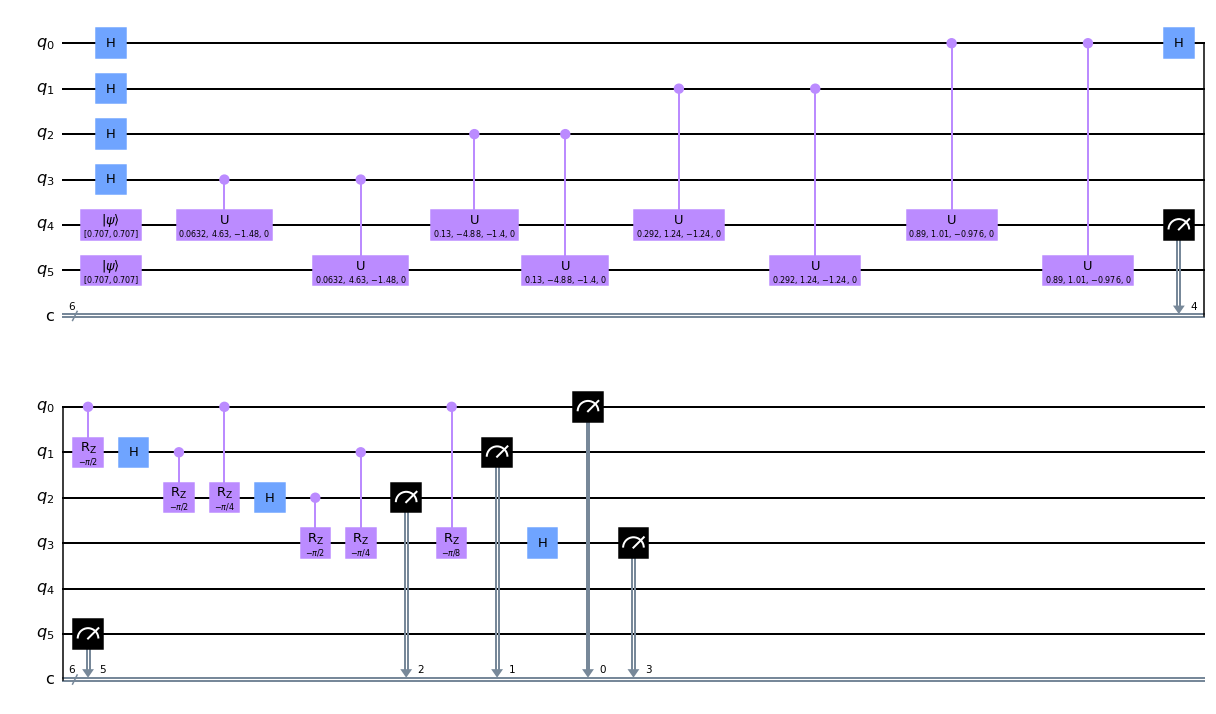

In [83]:
circuit.draw(output='mpl')

In [9]:
def findBackend():
    m = sys.maxsize
    minIndex=-1
    for i,b in enumerate(provider.backends()):
        try:
            #qcount=b.configuration().n_qubits
            qcount=len(b.properties().qubits)
        except:
            qcount="(simulador) "+ str(b.configuration().n_qubits)
        if qcount==5 and b.status().pending_jobs<m and b.name()!='ibmq_bogota': 
            m = b.status().pending_jobs
            minIndex=i
        #print("{}, lista de espera: {}, {} qubits".format(b.name(), b.status().pending_jobs, qcount))

    backend=provider.backends()[minIndex]
    print("\n El backend real con menos cola de espera: ", backend.name())
    return backend

ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
xd
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila

 El backend real con menos cola de espera:  ibmq_quito


<IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>

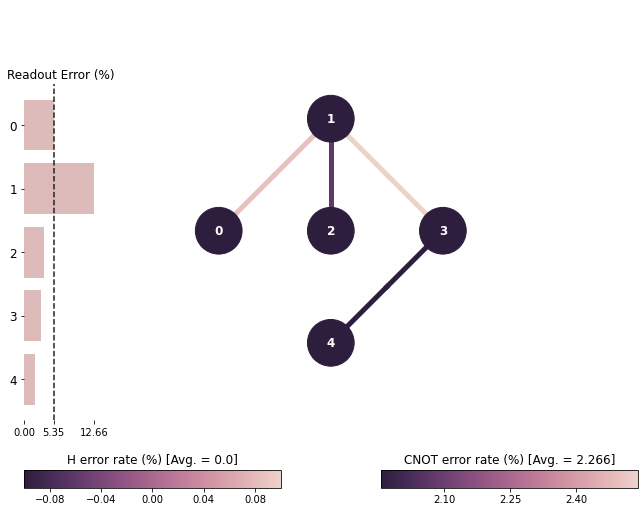

In [103]:
findBackend()

In [10]:
#Creacion del circuito QPE con n qubits superiores y m inferiores, la matriz de covarianza normalizada p y el vector estado
def QPE(n,m,p, stateVector):
    #Circuito con n+m qubits y bits clasicos
    #qpeCircuit=QuantumCircuit(n+m,n+m)
    qpeCircuit=QuantumCircuit(n+m)
    #Indices de los n qubits superiores
    nNumbers=np.arange(0,n).tolist()
    #Aplicar puertas de hadamard a los qubits superiores
    qpeCircuit.h(nNumbers)
    
    #Indices de los m qubits inferiores
    mNumbers=np.arange(n,n+m).tolist()
        #Iniciar m qubits inferiores con el vector de estado, trash
        #for i in range(n,n+m):
            #qpeCircuit.initialize(stateVector,i)
            #qpeCircuit.ry(1,i)
            #qpeCircuit.rz(0.33,i)
    #para m>1, inicializar el conjunto de m qubits inferiores
    if len(stateVector)==(2*len(mNumbers)):
        qpeCircuit.initialize(stateVector,mNumbers)
    else:
        raise ValueError('State vector incorrect length')
        
    #Aplicar las puertas controladas de U entre los qubits superiores e inferiores
    for i in range(0,n):
        #Calcular rotacion de la matriz de covarianza para la puerta controlada U
        (theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*(2**i)))
        #Aplicar rotaciones theta, phi, lambda, gamma=0
        qpeCircuit.cu(theta,phi,lamb, 0, n-1-i, mNumbers)
    
    #Llamar a la funcion de creacion de IQFT para los n qubits superiores
    iqftC=IQFT(n) 
    #Combinar los dos circuitos
    xd=QuantumCircuit.compose(qpeCircuit,iqftC)
    #Realizar las mediciones
    #xd.measure(nNumbers+mNumbers,nNumbers+mNumbers)
    xd.measure_all()
    return xd


#Creacion del circuito Inverse Quantum Fourier Transform con n qubits  
def IQFT(n):
    #Definir circuito de n qubits y n bits clasicos
    #iqftCircuit=QuantumCircuit(n,n)
    iqftCircuit=QuantumCircuit(n)
    
    #Aplicar las rotaciones respectivas a cada qubit, desde el 0 hasta el n-1
    for i in range(0,n):
        for j in range(0,i):
            iqftCircuit.crz(-np.pi/(2**(j+1)), (i-1-j),i)
        
        #Aplicar puerta de hadamard despues de aplicar las rotaciones en cada qubit
        iqftCircuit.h(i)    
    return iqftCircuit

#Creacion del circuito Inverse Quantum Fourier Transform con n qubits, Metodo 2 (paper Finances)
def IQFT2(n):
    iqftCircuit=QuantumCircuit(n)
    #Aplicar las rotaciones respectivas a cada qubit, desde el 0 hasta el n-1
    for i in range(0,n):
        #Aplicar puerta de hadamard antes de aplicar las rotaciones en cada qubit
        iqftCircuit.h(i)
        for j in range(i,n-1):
            iqftCircuit.crz(-np.pi/(2**(j+1)), i,j+1)
    return iqftCircuit

In [38]:
#Matriz de covarianza de los datos
cmat = np.cov(fsData, rowvar=False)
p=cmat/cmat.trace()


 El backend real con menos cola de espera:  ibmq_quito
Iteration  0

 El backend real con menos cola de espera:  ibmq_quito
Iteration  1
Eigenvector obtenido:  [0.479388844880931, 0.528680532637681, 0.48900964692182575, 0.5015503913178175]


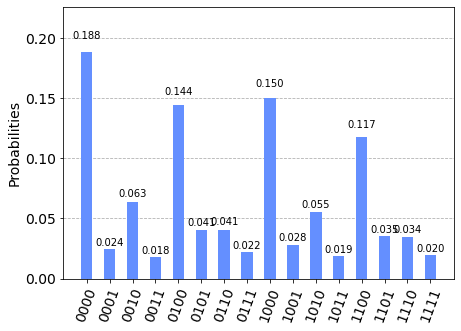

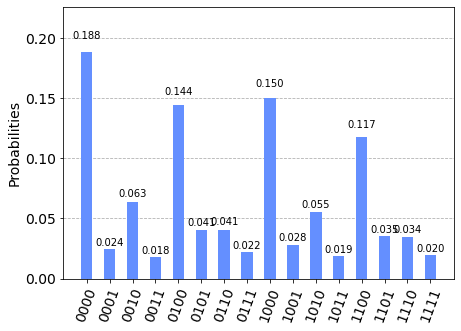

In [81]:
#Inicializar vector de estado |+>
#stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
stateVec = [1/2,1/2,1/2,1/2]
for i in range(0,2):
    circuit=QPE(2,2,p,stateVec)
    backend=findBackend()
    #results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=4096).result().get_counts()
    results = execute(circuit, backend=provider.get_backend('ibmq_belem'), shots=4096).result().get_counts()
    #Conteo de los estados relacionados con la proyeccion 11 (011 y 111)
    denominator = results['0011'] + results['0111'] + results['1011'] + results['1111']
    #Calcular coeficientes del eigenvector
    alpha1 = np.sqrt(results['0011'] / denominator)
    alpha2 = np.sqrt(results['0111'] / denominator)
    alpha3 = np.sqrt(results['1011'] / denominator)
    alpha4 = np.sqrt(results['1111'] / denominator)
    #Guardar nuevo estado inicial del qubit 2 para la siguiente ejecucion
    #stateVec = [alpha1, alpha2]
    #stateVec2= [alpha3, alpha4]
    stateVec = [alpha1, alpha2,alpha3,alpha4]
    print("Iteration ",i)
print("Eigenvector obtenido: ",stateVec)#stateVec+stateVec2)
plot_histogram(results)

In [24]:
print(QuantumRegister(2))

QuantumRegister(2, 'q424')


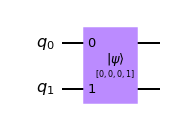

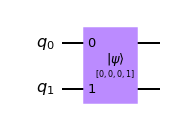

In [38]:
from qiskit.quantum_info import Statevector
sv = Statevector.from_label('11')
c=QuantumCircuit(2)
c.initialize(sv,[0,1])
c.draw()

In [12]:
#Funcion para calcular el eigenvector dada la matriz de densidad (matriz cov normalizada por la traza)
def circuitEigenvector(n,m,p):
    #Inicializar vector de estado |+>
    if len(p)==2:
        stateVec = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
        resultDict={}
        legend=[]
    elif len(p)==4:
        stateVec = np.array([1/2,1/2,1/2,1/2])
    else:
        raise ValueError('2x2 or 4x4 matrix sizes available only')
    #Cadena de 1s dependiendo del numero de qubits superiores
    chain=""
    for i in range(0,n):
        chain+="1"
    backend=findBackend()
    for i in range(0,10):
        circuit=QPE(n,m,p,stateVec)
        
        #results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=4096).result().get_counts()
        results = execute(circuit, backend=backend, shots=4096).result().get_counts()
        #Obtener los nombres de los resultados por orden de conteos de mayor a menor
        #arra=np.array(list(results.values()))
        #index = arra.argsort()[::-1]
        #arra=arra[index]
        #key=np.array(list(results.keys()))[index]
        #Conteo de los estados relacionados con la proyeccion 11 (011 y 111)
        #denominator = results[key[0]]+results[key[1]]+results[key[2]]+results[key[3]]
        if len(p)==2:
            denominator = results['0'+chain]+results['1'+chain]
            #Calcular coeficientes del eigenvector
            alpha1 = np.sqrt(results['0'+chain] / denominator)
            alpha2 = np.sqrt(results['1'+chain] / denominator)
            stateVec = [alpha1, alpha2]
            resultDict['Results'+str(i)]=results
            legend.append(str(i+1)+". execución")
        else:
            denominator = results['00'+chain]+results['01'+chain]+results['10'+chain]+results['11'+chain]
            #Calcular coeficientes del eigenvector
            alpha1 = np.sqrt(results['00'+chain] / denominator)
            alpha2 = np.sqrt(results['01'+chain] / denominator)
            alpha3 = np.sqrt(results['10'+chain] / denominator)
            alpha4 = np.sqrt(results['11'+chain] / denominator)
            #Guardar nuevo estado inicial del qubit para la siguiente ejecucion
            stateVec = [alpha1, alpha2, alpha3, alpha4]
    if len(p)==2:
        plot_histogram(resultDict.values(), legend=legend, figsize=(16,12.5), color=plt.inferno())
    plot_histogram(results)
    print("Eigenvector obtenido: ",stateVec)
    return stateVec

In [12]:
ev=circuitEigenvector(2,1,p)

Traceback (most recent call last):
  File "<ipython-input-12-7cd4b1bcdd6e>", line 1, in <module>
    ev=circuitEigenvector(2,1,p)
NameError: name 'p' is not defined

Use %tb to get the full traceback.


Iteracion  0

 El backend real con menos cola de espera:  ibmq_belem
Eigenvector obtenido:  [0.7604346583140575, 0.6494144519756105]
Iteracion  1

 El backend real con menos cola de espera:  ibmq_belem


/opt/conda/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized [<qiskit.dagcircuit.dagnode.DAGNode object at 0x7eff63d5cac0>, <qiskit.dagcircuit.dagnode.DAGNode object at 0x7eff63d5ce80>, <qiskit.dagcircuit.dagnode.DAGNode object at 0x7eff63d5c6a0>, <qiskit.dagcircuit.dagnode.DAGNode object at 0x7eff63d5c580>] and got       ┌───────┐┌────┐┌─────────────┐┌────┐┌───────────────┐
qr_0: ┤ Rz(π) ├┤ √X ├┤ Rz(-3.1416) ├┤ √X ├┤ Rz(3.519e-12) ├
      └───────┘└────┘└─────────────┘└────┘└───────────────┘, but the original was native and the new value is longer.  This indicates an efficiency bug in synthesis.  Please report it by opening an issue here: https://github.com/Qiskit/qiskit-terra/issues/new/choose
  new_dag = pass_.run(dag)
/opt/conda/lib/python3.8/site-packages/qiskit/transpiler/runningpassmanager.py:166: UserWarning: Resynthesized [<qiskit.dagcircuit.dagnode.DAGNode object at 0x7eff63d53280>, <qiskit.dagcircuit.dagnode.DAGNode object at

Eigenvector obtenido:  [0.6526300069150406, 0.7576767609436587]
Eigenvectores obtenidos en orden 
 [[0.76043466 0.65263001]
 [0.64941445 0.75767676]]
EIgenvalores obtenidos en orden 
 [0.99241618 0.99240608]
QSVMData=2 Dimensiones


<Figure size 432x288 with 0 Axes>

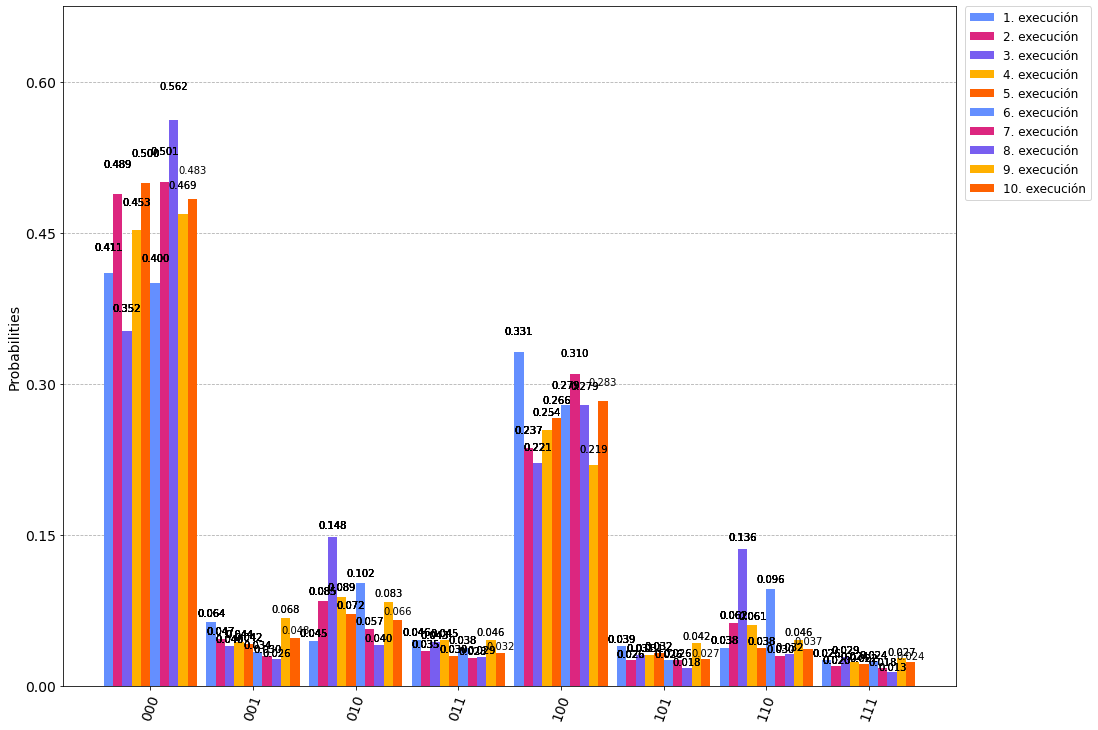

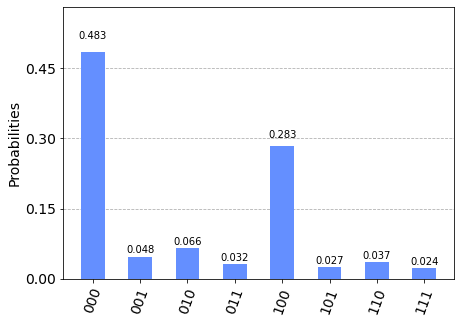

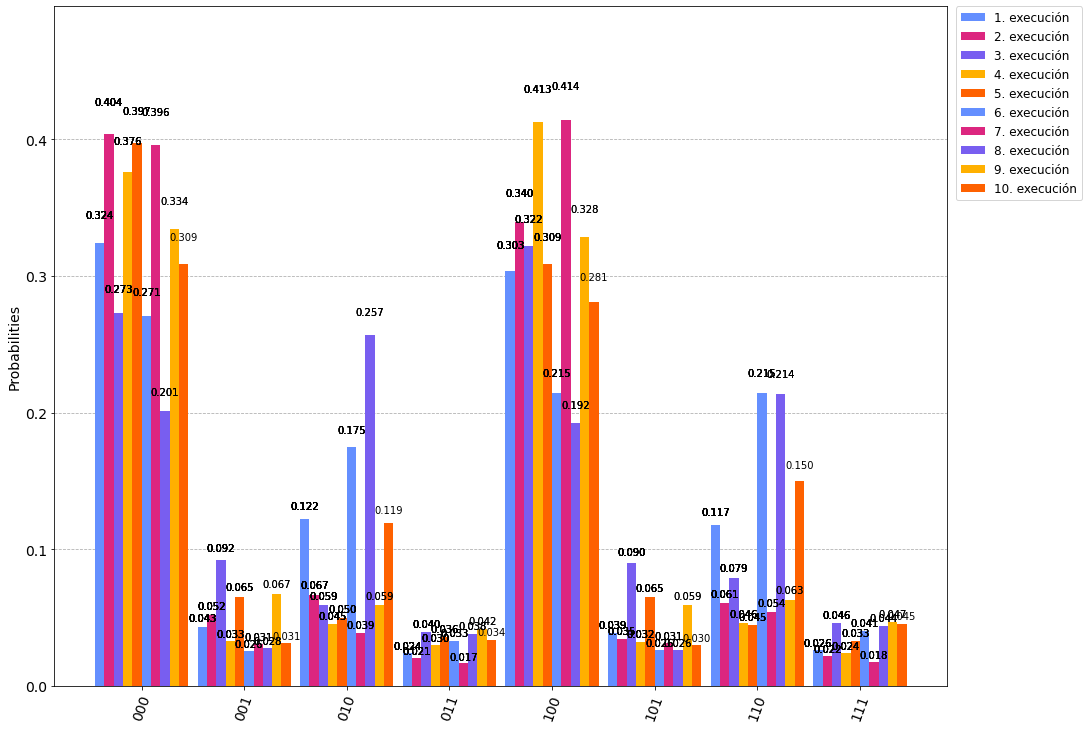

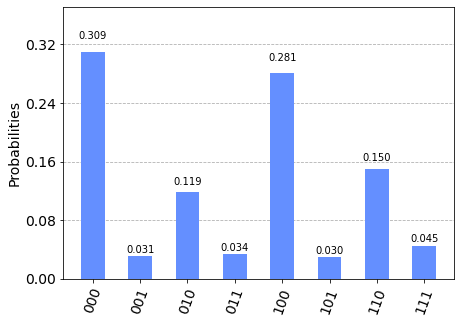

In [16]:
#Matriz de covarianza de los datos
cmat = np.cov(fsData, rowvar=False)
#Matriz de densidad
p=cmat/cmat.trace()

#eigenvectors=np.zeros((len(cmat),3))
eigenvectors=np.zeros((len(cmat),len(cmat)))
eigenvalues=np.zeros(len(cmat))

#Siendo 4 variables, se busca reducir a las 3 mejores. Con 2 variables reducir a 1.
for i in range(0, len(eigenvectors)):
    print("Iteracion ",i)
    ev=circuitEigenvector(2,1,p)
    eigenvalue1,cmat=eigenvalue(np.asarray(ev), cmat, fsData)
    eigenvectors[:,i]=ev
    p=cmat/cmat.trace()
    eigenvalues[i]=eigenvalue1
print("Eigenvectores obtenidos en orden \n", eigenvectors)
print("EIgenvalores obtenidos en orden \n", eigenvalues)
if (len(cmat)==2):
    qsvmData =np.dot(fsData, eigenvectors[:,0:2])
    print("QSVMData=2 Dimensiones")
elif (len(cmat)==4):
    qsvmData =np.dot(fsData, eigenvectors[:,0:3])
    #qsvmData =np.dot(fsData, eigenvectors[:,0:len(cmat)-1])

In [69]:
print(eigenval)
xd,c=eigenvalue(eigenvec[:,0], cmat, fsData)
eiv,ev=np.linalg.eig(c)
print(eiv)

[1.15424417 1.01364385 0.93552748 0.89717395]
[-13.32780159   0.21207261   0.8259705    0.95687106]


### Guardar datos obtenidos por proyeccion Quantum Eigen

In [17]:
#Guardar qsvmData en fichero csv
print(qsvmData[0,:]) #qsvmData.shape = (6787,3) o  (6787,2) en caso de 2 dims
print(qsvmData.shape)
np.savetxt('qsvmData2DIM.csv', qsvmData, delimiter=',', fmt='%1.8f')#Escribir en fichero con 8 decimales de precision

[-0.41347877 -0.47712635]
(6787, 2)


### Leer datos Quantum Eigen

In [41]:
#qsvmDataPrueba=pd.read_csv('qsvmData.csv', sep=',', header=None).to_numpy()#.reshape(-1) #leer fichero de datos
#print(qsvmDataPrueba.shape)
#print(qsvmDataPrueba[0,:])
#print(np.allclose(qsvmData, qsvmDataPrueba))#iguales
qsvmData=pd.read_csv('qsvmData.csv', sep=',', header=None).to_numpy()
print(qsvmData[0,:])

[-0.34303079 -0.38221095 -0.31143755]


In [11]:
choco=np.array([[0.39735971, 0.31370798, 0.33783196, 0.27518749],
 [0.60697698, 0.52250921, 0.57104024, 0.37390617],
 [0.36273813, 0.47140452, 0.53669682, 0.36603358],
 [0.58489765, 0.63745526, 0.52128604, 0.80652677]])#eigenvectors obtenidos
chocobo=np.dot(fsData,choco[:,0:3])
print(chocobo[0,:])

[-0.34303079 -0.38221095 -0.31143755]
[[0.39735971 0.31370798 0.33783196]
 [0.60697698 0.52250921 0.57104024]
 [0.36273813 0.47140452 0.53669682]
 [0.58489765 0.63745526 0.52128604]]


# LOF

In [12]:
from sklearn.neighbors import LocalOutlierFactor
model1 = LocalOutlierFactor()
y_pred = model1.fit_predict(data)

In [13]:
print(y_pred)

[-1 -1 -1 ...  1 -1  1]


[ 21.91271998  47.00942085  70.19584196 100.        ]


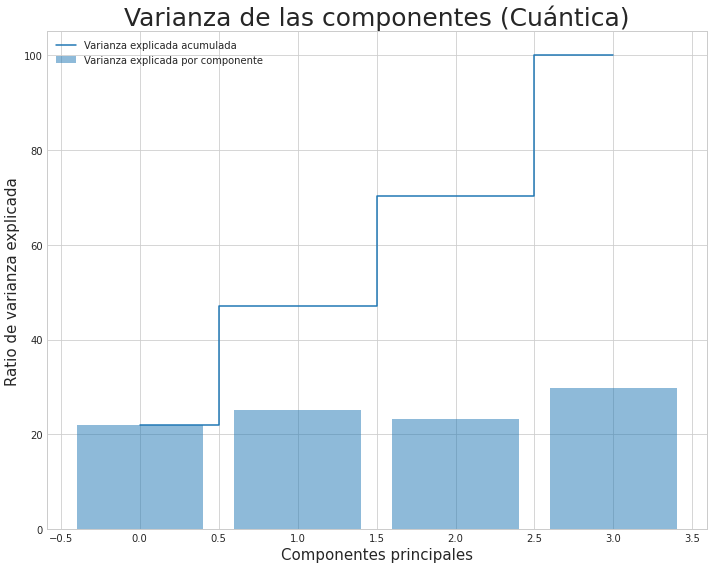

In [13]:
choco=np.array([[0.39735971, 0.31370798, 0.33783196, 0.27518749],
 [0.60697698, 0.52250921, 0.57104024, 0.37390617],
 [0.36273813, 0.47140452, 0.53669682, 0.36603358],
 [0.58489765, 0.63745526, 0.52128604, 0.80652677]])
cheigenvals=np.array([0.63460657,0.72681672,0.67149378,0.86314773])
explainedVar=cheigenvals/sum(cheigenvals)*100
cumVar = explainedVar.cumsum()
print(cumVar)
import seaborn as sns
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 8))

    plt.bar(range(4), explainedVar, alpha=0.5, align='center',
            label='Varianza explicada por componente')
    plt.step(range(4), cumVar, where='mid',
             label='Varianza explicada acumulada')
    plt.title('Varianza de las componentes (Cuántica)', fontsize=25)
    plt.ylabel('Ratio de varianza explicada', fontsize=15)
    plt.xlabel('Componentes principales', fontsize=15)
    plt.legend(loc='best')
    plt.savefig("VarianzaCuantica.pdf", 
               bbox_inches='tight')
    plt.tight_layout()

In [79]:
np.random.seed(999)
#np.random.seed(111)
#ind=np.random.randint(0,len(qsvmData),size = 75)
#ind=np.random.randint(0,len(qsvmData),size = 120)
ind=np.random.randint(0,len(data),size = 300)
X=data.to_numpy()[ind,1:15].real#.reshape(-1,2)
y=data.to_numpy()[ind,0].real

In [80]:
import sklearn#####UTILIZADO PARA LOS EIGENS QPCA
from sklearn.svm import SVR, OneClassSVM
from sklearn.model_selection import GridSearchCV
params= [{'kernel': ['linear'], 'tol': [1e-2, 1e-3, 1e-4,1e-5]},
        {'kernel': ['poly'], 'gamma': [1e-3, 1e-4,'scale'],
                     'degree':[2,3,4,5],
                     'tol': [1e-2, 1e-3, 1e-4,1e-5]},
        {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4,'scale'],
                     'tol': [1e-2, 1e-3, 1e-4,1e-5]},
         {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4,'scale'],
                     'tol': [1e-2, 1e-3, 1e-4,1e-5]}]
svr = GridSearchCV(OneClassSVM(), params, scoring='r2')
#svr=SVR(kernel='rbf',degree=5)
svr.fit(X,y)
#svr.score(X,y)
print("Mejor conjunto de parametros encontrados:\n\n")
print(svr.best_params_)

Mejor conjunto de parametros encontrados:


{'gamma': 0.0001, 'kernel': 'rbf', 'tol': 0.01}


In [81]:
means = svr.cv_results_['mean_test_score']
stds = svr.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, svr.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

-1.152 (+/-0.324) for {'kernel': 'linear', 'tol': 0.01}
-1.113 (+/-0.474) for {'kernel': 'linear', 'tol': 0.001}
-1.115 (+/-0.342) for {'kernel': 'linear', 'tol': 0.0001}
-1.115 (+/-0.359) for {'kernel': 'linear', 'tol': 1e-05}
-1.046 (+/-0.575) for {'degree': 2, 'gamma': 0.001, 'kernel': 'poly', 'tol': 0.01}
-1.005 (+/-0.376) for {'degree': 2, 'gamma': 0.001, 'kernel': 'poly', 'tol': 0.001}
-1.336 (+/-0.223) for {'degree': 2, 'gamma': 0.001, 'kernel': 'poly', 'tol': 0.0001}
-1.324 (+/-0.255) for {'degree': 2, 'gamma': 0.001, 'kernel': 'poly', 'tol': 1e-05}
-0.994 (+/-0.604) for {'degree': 2, 'gamma': 0.0001, 'kernel': 'poly', 'tol': 0.01}
-0.994 (+/-0.604) for {'degree': 2, 'gamma': 0.0001, 'kernel': 'poly', 'tol': 0.001}
-1.046 (+/-0.575) for {'degree': 2, 'gamma': 0.0001, 'kernel': 'poly', 'tol': 0.0001}
-1.005 (+/-0.376) for {'degree': 2, 'gamma': 0.0001, 'kernel': 'poly', 'tol': 1e-05}
-1.310 (+/-0.221) for {'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'tol': 0.01}
-1.310 (+/-